In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
# Day 1
obs1   = pd.read_csv("observations_round_4_day_1.csv")
prices1= pd.read_csv("prices_round_4_day_1.csv", sep=";")
trades1= pd.read_csv("trades_round_4_day_1.csv", sep=";")

# Repeat for days 2 & 3
obs2   = pd.read_csv("observations_round_4_day_2.csv")
prices2= pd.read_csv("prices_round_4_day_2.csv", sep=";")
trades2= pd.read_csv("trades_round_4_day_2.csv", sep=";")

obs3   = pd.read_csv("observations_round_4_day_3.csv")
prices3= pd.read_csv("prices_round_4_day_3.csv", sep=";")
trades3= pd.read_csv("trades_round_4_day_3.csv", sep=";")


In [4]:
obs_all    = pd.concat([obs1, obs2, obs3], ignore_index=True)
prices_all = pd.concat([prices1, prices2, prices3], ignore_index=True)
trades_all = pd.concat([trades1, trades2, trades3], ignore_index=True)


In [6]:
# 4. Extract mid‑prices for “MAGNIFICENT_MACARONS” and sugar, plus sunlight
#    — make sure to use bracket notation for column names

# MACARONS
macaron = (
    prices_all[prices_all["product"] == "MAGNIFICENT_MACARONS"]
    .set_index("timestamp")["mid_price"]
)

# SUGAR (from observations.csv)
sugar = (
    obs_all
    .set_index("timestamp")["sugarPrice"]
)

# SUNLIGHT
sun = (
    obs_all
    .set_index("timestamp")["sunlightIndex"]
)

# Combine into one DataFrame, drop any timestamps where any of the three is missing
df = (
    pd.DataFrame({
        "macaron_mid": macaron,
        "sugar_mid":   sugar,
        "sunlight":    sun
    })
    .dropna()
    .sort_index()
)


In [7]:
# here we use macaron returns; you can repeat for sugar
df["macaron_ret"] = df.macaron_mid.pct_change().shift(-1)

In [10]:
# pick candidate thresholds in the observed sunlight range
cands = np.linspace(df.sunlight.min(), df.sunlight.max(), 100)
corrs = []
for t in cands:
    flag = (df.sunlight < t).astype(int)
    # skip t if flag is constant
    if flag.std() == 0:
        corrs.append(np.nan)
        continue
    valid = flag.notna() & df.macaron_ret.notna()
    if valid.sum() < 10:
        corrs.append(np.nan)
        continue
    corrs.append(pearsonr(flag[valid], df.macaron_ret[valid])[0])

best_idx = np.nanargmin(corrs)
CSI      = cands[best_idx]

print(f"Calibrated CSI = {CSI:.2f}, corr = {corrs[best_idx]:.3f}")


Calibrated CSI = 44.75, corr = -0.439


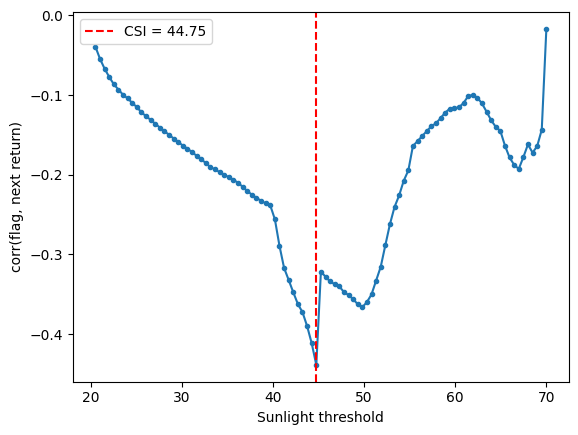

In [13]:
plt.plot(cands, corrs, marker=".")
plt.axvline(CSI, color="red", linestyle="--",
            label=f"CSI = {CSI:.2f}")
plt.xlabel("Sunlight threshold")
plt.ylabel("corr(flag, next return)")
plt.legend()
plt.show()


In [15]:
# %% [markdown]
# ## 2. Multivariate cost regression
# Now we’ll regress the macaron mid‐price on *all* of its cost components,
# and take the sugarPrice coefficient as our refined “sugar units per macaron.”

# %%
import pandas as pd
import numpy as np
from glob import glob
from sklearn.linear_model import LinearRegression

# -- 2.1) Load & concat 3 days of raw files --
obs_files   = sorted(glob("observations_round_4_day_*.csv"))
price_files = sorted(glob("prices_round_4_day_*.csv"))

# Observation file must contain:
#    timestamp, sugarPrice, sunlightIndex, transportFees, importTariff, exportTariff
obs = pd.concat((pd.read_csv(f) for f in obs_files), ignore_index=True)

# Prices file: has per‐product order‑book snapshots
prices = pd.concat((pd.read_csv(f, sep=";") for f in price_files), ignore_index=True)

# -- 2.2) Extract just sugar & conversion costs, and macaron mid‐price --
sugar = obs[["timestamp","sugarPrice","sunlightIndex",
             "transportFees","importTariff","exportTariff"]]
mac   = prices.query("product=='MAGNIFICENT_MACARONS'")\
               [["timestamp","mid_price"]]

# -- 2.3) Merge on timestamp --
df = pd.merge(mac, sugar, on="timestamp")

# -- 2.4) (Optional) filter to “normal” regime so we don’t pick up panic spikes --
CSI = 44.75
df_norm = df[df.sunlightIndex >= CSI].copy()

# -- 2.5) Build your design matrix X and target y --
storage_cost = 0.1
df_norm["storageCost"] = storage_cost

X = df_norm[[
    "sugarPrice",      # raw sugar cost
    "transportFees",
    "importTariff",
    "exportTariff",
    "storageCost"
]]
y = df_norm.mid_price

# -- 2.6) Fit a linear model & inspect coefficients --
model = LinearRegression(fit_intercept=True)
model.fit(X, y)

coeffs = pd.Series(
    [model.intercept_] + model.coef_.tolist(),
    index = ["intercept"] + X.columns.tolist()
)
print("Regression coefficients:\n", coeffs.round(4))

# sugar‑per‑macaron is:
U = coeffs["sugarPrice"]
print(f"\n⇒ Estimated sugar units per macaron (U): {U:.3f}")


Regression coefficients:
 intercept       -247.5378
sugarPrice         3.7571
transportFees     48.3509
importTariff      -9.8766
exportTariff       3.8600
storageCost        0.0000
dtype: float64

⇒ Estimated sugar units per macaron (U): 3.757
